![microsoft logo](./images/Microsoft.jpg)
# <center> Phase 2 Project: King County Real Estate <center>
   <center>  By: Anat Jacobson, Keanan Ginell and Max Ross


# <font color='red'> Overview and Business Problem:
![cool pic of studio](./images/epic_set.jpg)
    
Our conclusions after the below analysis include identifying: 
1. What features impact sale price
2. How can this real-estate company personalize the service they provide


# <font color='red'> Data Exploration and Analysis:

In [1]:
# import 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster, FastMarkerCluster
import statsmodels.api as sm
from scipy import stats
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler



In [2]:
# Load the dataset into a DataFrame
df = pd.read_csv('data/updated_housing.csv')

### Checking info for nulls and Dtype

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29211 entries, 0 to 29210
Data columns (total 33 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             29211 non-null  int64  
 1   date           29211 non-null  object 
 2   price          29211 non-null  float64
 3   bedrooms       29211 non-null  int64  
 4   bathrooms      29211 non-null  float64
 5   sqft_living    29211 non-null  int64  
 6   sqft_lot       29211 non-null  int64  
 7   floors         29211 non-null  float64
 8   waterfront     29211 non-null  object 
 9   greenbelt      29211 non-null  object 
 10  nuisance       29211 non-null  object 
 11  view           29211 non-null  object 
 12  condition      29211 non-null  object 
 13  grade          29211 non-null  object 
 14  heat_source    29182 non-null  object 
 15  sewer_system   29198 non-null  object 
 16  sqft_above     29211 non-null  int64  
 17  sqft_basement  29211 non-null  int64  
 18  sqft_g

**Notes:**
- Length: 29211
- Several object dtypes
- heat_source and sewer_system have nulls

### Looking further into the null and duplicate values

In [4]:
df.isna().sum()

id                0
date              0
price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront        0
greenbelt         0
nuisance          0
view              0
condition         0
grade             0
heat_source      29
sewer_system     13
sqft_above        0
sqft_basement     0
sqft_garage       0
sqft_patio        0
yr_built          0
yr_renovated      0
address           0
lat               0
long              0
geometry          0
MHHI1             0
traffic_de        0
toxic_rele        0
hazardou_2        0
SCHDST            0
NAME              0
DSTNUM            0
dtype: int64

In [5]:
# locating duplicates
print(f'Number of Duplicates: {df.duplicated().sum()}')
df.loc[df.duplicated() == True]

Number of Duplicates: 1


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,lat,long,geometry,MHHI1,traffic_de,toxic_rele,hazardou_2,SCHDST,NAME,DSTNUM
24338,1233100736,9/28/2021,2600000.0,3,4.0,3500,8455,2.0,NO,NO,...,47.68069,-122.172135,POINT (-122.172135 47.680690000000006),95625.0,6.0,3786.715617,2.0,414,Lake Washington,17414


# Pulling zipcode
- split and zipcode is third from last

In [6]:
df['zipcode'] = df['address'].str.split().apply(lambda x: x[-3]).str.replace(',','').astype(int)

### Function for droping duplicates, nulls, and other specified columns

In [7]:
def dropper(df, one=None, two=None, three=None):
    '''
    Input: DataFrame, request 1,request 2, request 3
    requests:
    'duplicates' to drop duplicates
    'nulls' to drop null values
    list containing df column names l = ['','','']
    '''
    request = [one,two,three]
    if 'duplicates' in request:
        df = df.drop_duplicates()
    if 'nulls' in request:
        df = df.dropna()
    for req in request:
        if isinstance(req, list):
            df = df.drop(columns=req, axis=1).reset_index(drop=True)
    return(df)

**Below we drop duplicates and null values, in total there is only 1 duplicated row and 42 null values**

In [8]:
drop =['id','geometry','address','NAME','DSTNUM','date','lat','long']
drop_plots = ['id','geometry','address','NAME','DSTNUM','date']
# Data set for analysis
df_clean = dropper(df, 'duplicates', 'nulls', drop)
# Data set for ploting
df_plot = dropper(df,'duplicates', 'nulls', drop_plots)

### Checking for Catagoricals

In [9]:
categoricals = df_clean.select_dtypes("object")

for col in categoricals:
    print(df_clean[col].value_counts(), "\n")

NO     28664
YES      506
Name: waterfront, dtype: int64 

NO     28401
YES      769
Name: greenbelt, dtype: int64 

NO     24166
YES     5004
Name: nuisance, dtype: int64 

NONE         25651
AVERAGE       1891
GOOD           868
EXCELLENT      545
FAIR           215
Name: view, dtype: int64 

Average      17581
Good          8046
Very Good     3258
Fair           224
Poor            61
Name: condition, dtype: int64 

7 Average        11547
8 Good            8852
9 Better          3587
6 Low Average     2848
10 Very Good      1347
11 Excellent       402
5 Fair             385
12 Luxury          122
4 Low               46
13 Mansion          24
3 Poor               9
2 Substandard        1
Name: grade, dtype: int64 

Gas                  20147
Electricity           5950
Oil                   2899
Gas/Solar               93
Electricity/Solar       57
Other                   20
Oil/Solar                4
Name: heat_source, dtype: int64 

PUBLIC                24833
PRIVATE               

# converting to numeric types

In [10]:
def numeric_housing(df): 
    '''
    This function converts all boolean or rating types into numerics from input df. 
    this is saved as df_numeric
    This only works with housing data
    '''
    
    def convert_boolean(df,x=None):
        '''
        This function converts all boolean data into numeric types
        Used in numeric_df
        input dataframe
        '''
        boolean_cols = df.select_dtypes(include='object').columns
        column_name = []
        for col in boolean_cols:
            if set(df[col].unique()) == {'YES', 'NO'}:
                df[col] = df[col].replace({"NO": 0, "YES": 1})
                column_name.append(col)

        print(f'Boolean Conversions:{column_name}')
        return(df)

    df_numeric = df.copy()

    # Returns the new df_clean and lists the columns changed
    convert_boolean(df_numeric,1)

    # adjusting view column 
    # View has no intupretation written so it was self interpreted
#     df_numeric["view"] = df_numeric["view"].replace({"NONE": 0, "FAIR": 1, "AVERAGE": 2, "GOOD": 3, "EXCELLENT": 4,})

    # adjusting condition column 
    # View https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r#c 
    # under building condition it lists the order
    df_numeric["condition"] = df_numeric["condition"].replace({"Poor": 0, "Fair": 1, "Average": 2,
                                                               "Good": 3, "Very Good": 4,})
                                                
        
    # adjusting grade column 
    # View https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r#c 
    # under building grade it lists the order
    # they list the assosiated number with in name, i replaced it to just be the number
    df_numeric["grade"] = df_numeric["grade"].replace({"2 Substandard": 2,  "3 Poor": 3, "4 Low": 4, "5 Fair": 5,
                                                       "6 Low Average": 6, "7 Average": 7, "8 Good": 8, 
                                                       "9 Better": 9, "10 Very Good": 10, "11 Excellent": 11, 
                                                       "12 Luxury": 12, "13 Mansion": 13,})
                               
    df_numeric['renovated']= df_numeric['yr_renovated'].apply(lambda x: 1 if x !=0 else 0)
    #df_numeric = df_numeric.drop(columns='yr_renovated')
    
    adjusted = ['view','condition', 'grade','date']
    
    print(f'Rating Conversions: {adjusted}')
#     print(display(df_numeric.head()))
    return(df_numeric)
df_clean = numeric_housing(df_clean)

Boolean Conversions:['waterfront', 'greenbelt', 'nuisance']
Rating Conversions: ['view', 'condition', 'grade', 'date']


# Checking Correlation of Numeric Features

In [11]:
def correlation(df,column=None,rank=None):
    '''
    performs correlation matrix, drops no numeric object types
    variables are dataframe, column, and ranking
    ranking is optional
    column = 'column'
    rank = True for # rank 1,2,3...
    
    '''
    # RRedundant check. Makes sure all columns of object type are dropped
    df_object = df.select_dtypes(include='object')
    print(f'The following columns were dropped due to being object types\n{df_object.columns}')
    df = df.drop(df_object,axis=1) 
    df1 = df
    if rank is True:
        try:
            df_corr = df1.corr()[column]
            df_corr = df_corr.drop(column)
            print(f'Ranked correlation to {column}')
            return(df_corr.rank(ascending=False).sort_values())
        except:
            df_corr = df1.corr()
            return(df_corr.rank(ascending=False))
    else:    
        try:
            df_corr = df.corr()[column]
            df_corr = df_corr.drop(column)
            print(f'Correlation to {column}')
            return(df_corr.sort_values(ascending=False))
        except:
            df_corr = df1.corr()
            return(df_corr)

### Correlation to price

The following columns were dropped due to being object types
Index(['view', 'heat_source', 'sewer_system'], dtype='object')


Text(0.5, 1.0, 'Variables Correlating with Price')

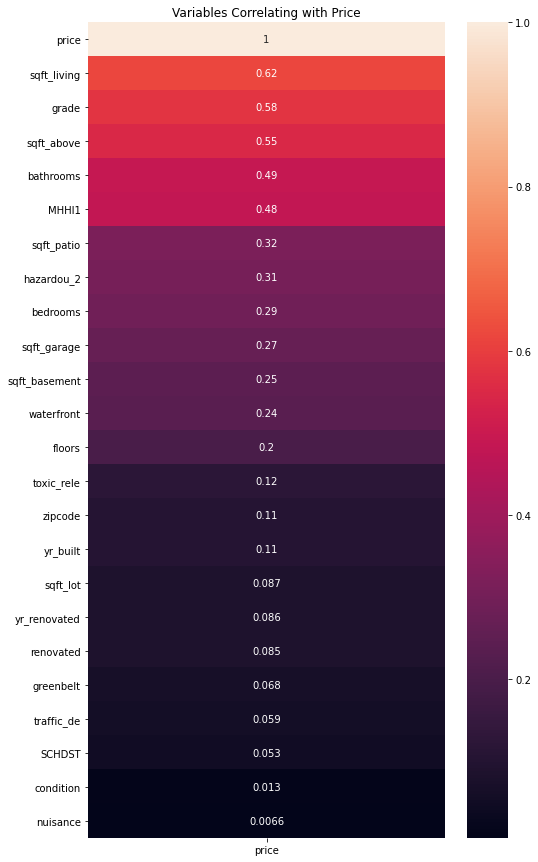

In [12]:
# df_clean_cor = df_clean[['price','sqft_living','grade','sqft_above','bathrooms','MHHI1']]
df_corr = abs(correlation(df_clean))
fig, ax = plt.subplots(figsize=(8,15))
sns.heatmap(df_corr[['price']].sort_values(by='price',ascending=False), annot=True)

ax.set_title('Variables Correlating with Price')
# plt.savefig('Group_plots/correlation_plot.png', dpi=100)

<AxesSubplot:>

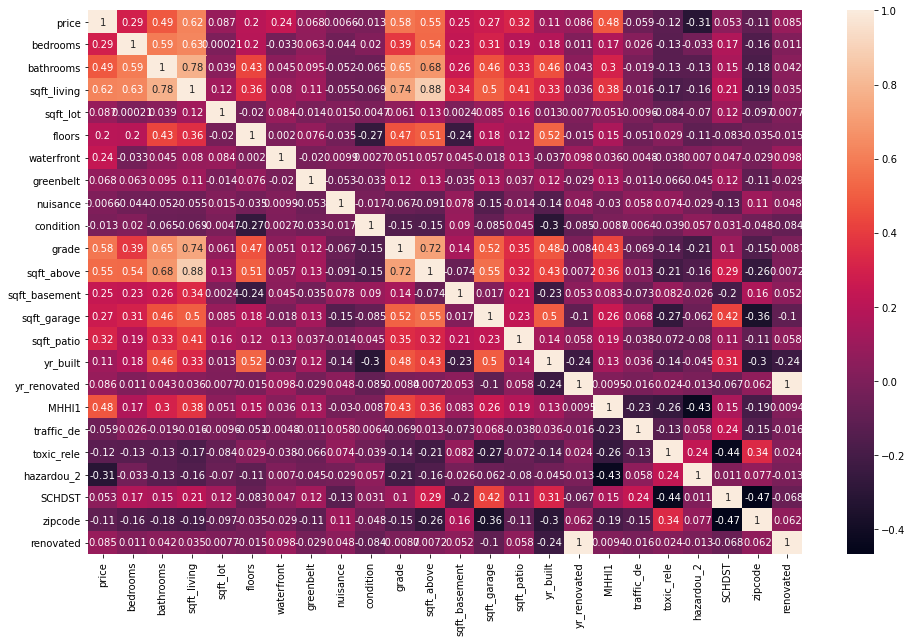

In [13]:
# Full correlation matrix
fig, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(df_clean.corr(), annot=True,ax=ax)

**Features with absolute correlation over 50%**

<AxesSubplot:>

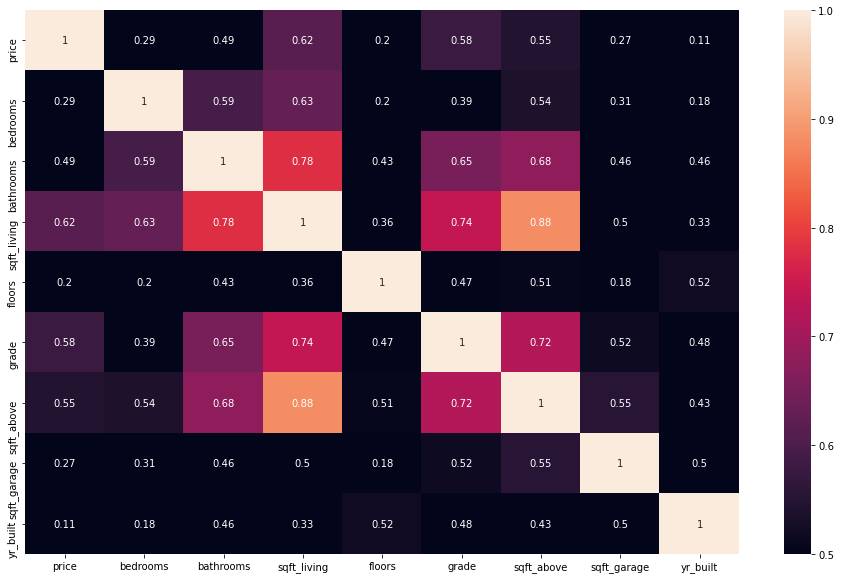

In [14]:
# Features 
df_cc = abs(df_clean.corr())
threshold = (df_cc > .5) & (df_cc < .99)
df_ccf = df_cc.loc[threshold.any(axis=1),threshold.any(axis=0)]
fig, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(df_ccf, annot=True,ax=ax,vmin=.5)

**Identifying highly correlating pairs**

In [15]:
# stack creates a series of tuples
filters = df_ccf[threshold].stack()

# sorts each tuple so any xy and yx will now all be xy and xy
# when using sorted each variable becomes a list so they need to be converted back to a tuple
#lastly now peform a set on the tuples
filtered = set(tuple(sorted(l,reverse=True)) for l in list(filters.index))
# for f in filtered:
print(f'Highley correlating Features:\n')
list(map(print, sorted(filtered)));

Highley correlating Features:

('bedrooms', 'bathrooms')
('grade', 'bathrooms')
('price', 'grade')
('sqft_above', 'bathrooms')
('sqft_above', 'bedrooms')
('sqft_above', 'floors')
('sqft_above', 'grade')
('sqft_above', 'price')
('sqft_garage', 'grade')
('sqft_garage', 'sqft_above')
('sqft_living', 'bathrooms')
('sqft_living', 'bedrooms')
('sqft_living', 'grade')
('sqft_living', 'price')
('sqft_living', 'sqft_above')
('sqft_living', 'sqft_garage')
('yr_built', 'floors')


# Creating Dummy variables

In [16]:
def for_dummies(df,columns):
    '''
    (dataframe, column name or list)
    creates a dummy variable for each specified column, 
    drops column with heighest value count
    columns: 'column' or ['column1','column2',...]
    '''
    if isinstance(columns, str):
        columns = [columns]
    for column in columns:
        if isinstance(df[column], object) == False:
            df[column] = df[column].astype(object)
        dropped = str(df[column].value_counts().idxmax())
        name_drop = column + '_' +dropped
        print(f'Dropped Column: {name_drop}')
        df_dum = pd.get_dummies(df, columns=[column], drop_first=False)
        df_dum = df_dum.drop(columns=name_drop)
        df = df_dum
    return(df)

In [17]:
onecode_model1 = ['SCHDST','view', 'sewer_system','yr_renovated']
onecode_model2 = ['SCHDST','view', 'sewer_system']
onecode_model3 = ['SCHDST','view', 'sewer_system','yr_renovated','zipcode']
df_model1 = for_dummies(df_clean, onecode_model1)
df_model2 = for_dummies(df_clean, onecode_model2)
df_model3 = for_dummies(df_clean, onecode_model3)

Dropped Column: SCHDST_1
Dropped Column: view_NONE
Dropped Column: sewer_system_PUBLIC
Dropped Column: yr_renovated_0
Dropped Column: SCHDST_1
Dropped Column: view_NONE
Dropped Column: sewer_system_PUBLIC
Dropped Column: SCHDST_1
Dropped Column: view_NONE
Dropped Column: sewer_system_PUBLIC
Dropped Column: yr_renovated_0
Dropped Column: zipcode_98042


In [18]:
df_model1

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,condition,...,yr_renovated_2013,yr_renovated_2014,yr_renovated_2015,yr_renovated_2016,yr_renovated_2017,yr_renovated_2018,yr_renovated_2019,yr_renovated_2020,yr_renovated_2021,yr_renovated_2022
0,675000.0,4,1.0,1180,7140,1.0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
1,728000.0,4,2.0,2170,7520,1.0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
2,645000.0,3,2.0,1520,8250,1.0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
3,760600.0,3,2.5,2570,2889,2.0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
4,624950.0,3,2.5,1610,8625,1.0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29165,380000.0,2,1.0,800,9927,1.5,0,0,1,2,...,0,0,0,0,0,0,0,0,0,0
29166,199000.0,2,1.0,1150,10098,1.5,0,0,1,2,...,0,0,0,0,0,0,0,0,0,0
29167,395000.0,1,1.0,620,10400,1.5,0,0,1,2,...,0,0,0,0,0,0,0,0,0,0
29168,328000.0,2,1.5,980,5000,2.0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0


# Modeling

# Creating Regression Models

In [19]:
list(df_model1.columns)

['price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'greenbelt',
 'nuisance',
 'condition',
 'grade',
 'heat_source',
 'sqft_above',
 'sqft_basement',
 'sqft_garage',
 'sqft_patio',
 'yr_built',
 'MHHI1',
 'traffic_de',
 'toxic_rele',
 'hazardou_2',
 'zipcode',
 'renovated',
 'SCHDST_210',
 'SCHDST_216',
 'SCHDST_400',
 'SCHDST_401',
 'SCHDST_402',
 'SCHDST_403',
 'SCHDST_404',
 'SCHDST_405',
 'SCHDST_406',
 'SCHDST_407',
 'SCHDST_408',
 'SCHDST_409',
 'SCHDST_410',
 'SCHDST_411',
 'SCHDST_412',
 'SCHDST_414',
 'SCHDST_415',
 'SCHDST_417',
 'SCHDST_888',
 'view_AVERAGE',
 'view_EXCELLENT',
 'view_FAIR',
 'view_GOOD',
 'sewer_system_PRIVATE',
 'sewer_system_PRIVATE RESTRICTED',
 'sewer_system_PUBLIC RESTRICTED',
 'yr_renovated_1924',
 'yr_renovated_1928',
 'yr_renovated_1940',
 'yr_renovated_1942',
 'yr_renovated_1945',
 'yr_renovated_1946',
 'yr_renovated_1947',
 'yr_renovated_1948',
 'yr_renovated_1949',
 'yr_renovated_1950',
 'yr_renovated_195

In [20]:
def mlr(df,column,model_type=None, simple=False):
    '''
    This runs a Simple and Multiple Linear Regression. 
    Auto returns summary, has options to only return fit or constant(X) 
    Simple runs with x as the feature with the heighest correlation to input feature (column)
    column : y column
    model_type : 'x' = sm.add_constant(X) / 'fit' = no summary, fitted model
    simple : True = simple  /  False = multiple
    '''
    # Remove any features that are object types
    df_object = df.select_dtypes(include='object')
    print(f'The following columns were dropped due to being object types\n{df_object.columns}')
    df1 = df.drop(df_object,axis=1)

    # simple or mulitple correlation 
    if simple == True:
        highest_corr = correlation(df, column).abs().idxmax()
        x = df[highest_corr]
    elif simple == False:
        x = df1.drop(column, axis=1)
        
    # Define the y variables
    y = df1[column]
    
    # Create model
    model_fit = sm.OLS(y,sm.add_constant(x)).fit()
    
    # model_type 
    if model_type == 'x':
        return(sm.add_constant(x))
    elif model_type == 'fit':
        return(model_fit)
    else:
        return(model_fit.summary())


# Simple Model

In [21]:
mlr(df_model1,'price',simple=True)

The following columns were dropped due to being object types
Index(['heat_source'], dtype='object')
The following columns were dropped due to being object types
Index(['heat_source'], dtype='object')
Correlation to price


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                 1.789e+04
Date:                Fri, 31 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:37:39   Log-Likelihood:            -4.3419e+05
No. Observations:               29170   AIC:                         8.684e+05
Df Residuals:                   29168   BIC:                         8.684e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -9.221e+04   9908.686     -9.306      0.000   -1.12e+05   -7.28e+04
sqft_living   565.3827      4.227    133.770      0.000     557.099     573.667
==============================================================================
Omnibus:                    42232.632   Durbin-Watson:                   1.224
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         50100657.663
Skew:                           8.242   Prob(JB):                         0.00
Kurtosis:                     205.359   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Notees:**
- Relatively high condition number

## Model 1

In [22]:
mlr(df_model1,'price')

The following columns were dropped due to being object types
Index(['heat_source'], dtype='object')


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     386.1
Date:                Fri, 31 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:37:40   Log-Likelihood:            -4.2674e+05
No. Observations:               29170   AIC:                         8.537e+05
Df Residuals:                   29042   BIC:                         8.548e+05
Df Model:                         127                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                            7.217e+07   1.23e+07      5.874      0.000    4.81e+07    9.63e+07
bedrooms                         -8.04e+04   4554.249    -17.653      0.000   -8.93e+04   -7.15e+04
bathrooms                        5.867e+04   6641.992      8.833      0.000    4.57e+04    7.17e+04
sqft_living                       125.9741     15.113      8.335      0.000      96.351     155.597
sqft_lot                            0.5496      0.058      9.460      0.000       0.436       0.663
floors                          -1.066e+05   8966.098    -11.889      0.000   -1.24e+05    -8.9e+04
waterfront                       8.275e+05   2.98e+04     27.772      0.000    7.69e+05    8.86e+05
greenbelt                       -7.151e+04   2.07e+04     -3.453      0.001   -1.12e+05   -3.09e+04
nuisance                         -2.05e+04   8812.619     -2.326      0.020   -3.78e+04   -3222.836
condition                        4.107e+04   5137.360      7.995      0.000     3.1e+04    5.11e+04
grade                            1.189e+05   5111.561     23.252      0.000    1.09e+05    1.29e+05
sqft_above                        311.7136     15.377     20.271      0.000     281.573     341.854
sqft_basement                      96.6194     11.488      8.410      0.000      74.102     119.137
sqft_garage                      -102.6475     16.468     -6.233      0.000    -134.925     -70.370
sqft_patio                         90.1651     15.009      6.007      0.000      60.746     119.584
yr_built                        -1170.7735    174.206     -6.721      0.000   -1512.225    -829.322
MHHI1                               3.9796      0.150     26.499      0.000       3.685       4.274
traffic_de                       1.177e+04   1369.461      8.594      0.000    9084.906    1.45e+04
toxic_rele                         -0.4080      0.144     -2.831      0.005      -0.690      -0.125
hazardou_2                      -2.936e+04   2986.372     -9.832      0.000   -3.52e+04   -2.35e+04
zipcode                          -718.2605    125.250     -5.735      0.000    -963.755    -472.766
renovated                       -3.126e+04   2.83e+04     -1.106      0.269   -8.67e+04    2.41e+04
SCHDST_210                      -4.308e+05   2.54e+04    -16.974      0.000   -4.81e+05   -3.81e+05
SCHDST_216                      -6.365e+05   2.75e+04    -23.178      0.000    -6.9e+05   -5.83e+05
SCHDST_400                       4.954e+05   3.51e+04     14.125      0.000    4.27e+05    5.64e+05
SCHDST_401                      -1.327e+05   1.98e+04     -6.707      0.000   -1.72e+05    -9.4e+04
SCHDST_402                       -3.61e+05   4.39e+04     -8.221      0.000   -4.47e+05   -2.75e+05
SCHDST_403                      -2.193e+05   2.13e+04    -10.292      0.000   -2.61

**Notes:**
- high condition number suggests high multicolinearity
- R^2 value is not bad but not great

# Checking if Transformations are Needed

In [23]:
def kde_plot(df,feature,legends=False):
    '''
    df : dataframe
    feature : column or list of columns
    legends: set to True, to show
    Example: kde_plot(df,'price') where kdeplot(data= df['price'])
    Note: if density varies significantly between features results will not be shown properly
    '''
    xy = df[feature]
    for f in feature:
        fig, ax = plt.subplots(figsize=(4, 2))
        sns.kdeplot(data=df[f],legend=legends, ax=ax)
#     fig, ax = plt.subplots(figsize=(6, 4))
#     sns.kdeplot(data=xy,legend=legends, ax=ax)
        plt.title(f'KDE plot of {f}')
        plt.xlabel(f)
        plt.ylabel('Density')

<ipython-input-23-a0539701fe2d>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(4, 2))


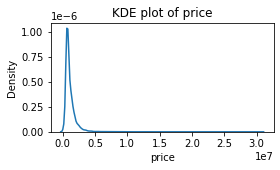

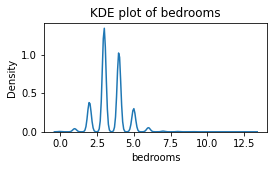

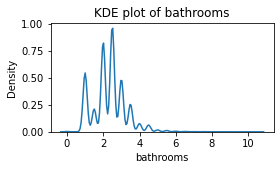

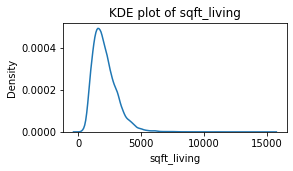

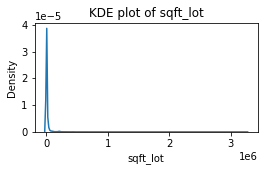

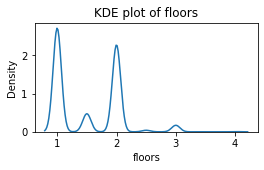

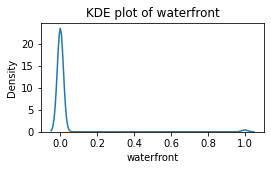

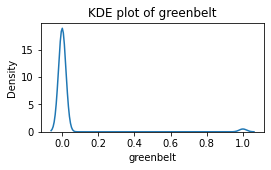

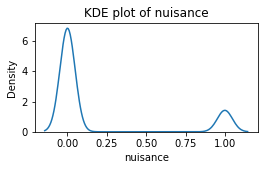

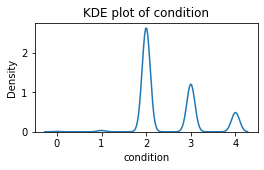

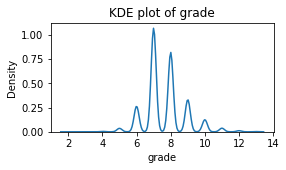

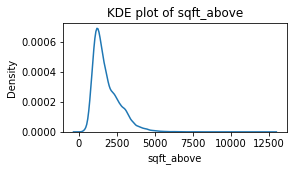

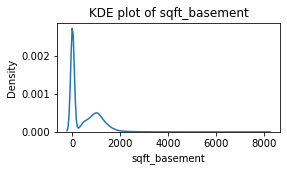

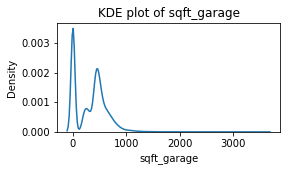

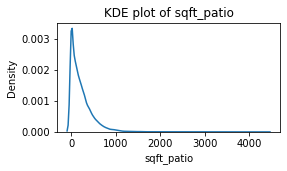

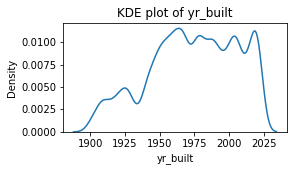

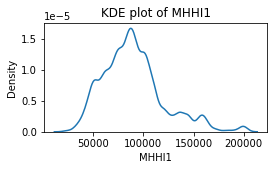

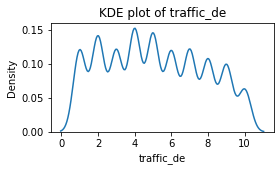

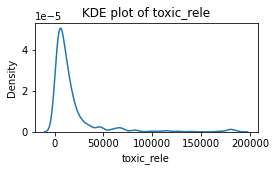

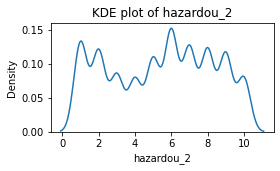

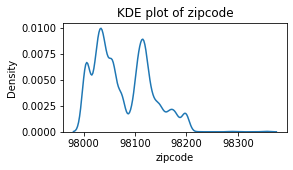

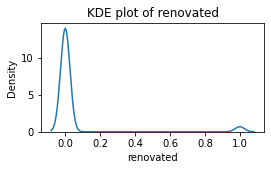

In [24]:
kde_list = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'greenbelt', 'nuisance', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built',
            'MHHI1', 'traffic_de', 'toxic_rele', 'hazardou_2','zipcode', 'renovated']
kde_plot(df_model1,kde_list)

**Notes:**
- price will likely need a log transformation
- Scale numerical variables

# Testing Scaling Numerical Variables

In [25]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

# Instanstiate SS from sklearn
ss = StandardScaler()

In [26]:
df_model1_sc = dropper(df_model1,['zipcode','renovated'])
df_scale_1 = df_model1_sc.copy()

# seperate dummies and non-dummies, also drop out boolean values 'waterfront','greenbelt', 'nuisance'

scale_columns = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','sqft_above',
                 'sqft_basement','sqft_garage','sqft_patio',
                'yr_built','MHHI1','toxic_rele','condition','grade','hazardou_2','traffic_de']
df_scale = df_scale_1[scale_columns]
df_dum = df_scale_1.drop(columns=scale_columns)

# Fit on data 
ss.fit(df_scale)

# Transform data
array_sc = ss.transform(df_scale)
df_sc = pd.DataFrame(array_sc, columns=df_scale.columns, index= list(df_scale.index))
df_full_sc = pd.concat([df_sc, df_dum], axis=1)

**Joining scaled dataframe to dummies df**

In [27]:
mlr(df_full_sc,'price')

The following columns were dropped due to being object types
Index(['heat_source'], dtype='object')


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     388.4
Date:                Fri, 31 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:37:45   Log-Likelihood:            -4.2676e+05
No. Observations:               29170   AIC:                         8.538e+05
Df Residuals:                   29043   BIC:                         8.548e+05
Df Model:                         126                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                            1.219e+06   8540.649    142.786      0.000     1.2e+06    1.24e+06
bedrooms                        -7.837e+04   4450.426    -17.609      0.000   -8.71e+04   -6.96e+04
bathrooms                         5.33e+04   5941.999      8.970      0.000    4.17e+04    6.49e+04
sqft_living                      1.213e+05   1.48e+04      8.218      0.000    9.24e+04     1.5e+05
sqft_lot                         3.322e+04   3535.604      9.396      0.000    2.63e+04    4.02e+04
floors                          -5.742e+04   4915.280    -11.681      0.000   -6.71e+04   -4.78e+04
sqft_above                       2.749e+05   1.35e+04     20.304      0.000    2.48e+05    3.01e+05
sqft_basement                    5.733e+04   6736.084      8.511      0.000    4.41e+04    7.05e+04
sqft_garage                     -2.985e+04   4714.520     -6.331      0.000   -3.91e+04   -2.06e+04
sqft_patio                       2.252e+04   3705.297      6.076      0.000    1.53e+04    2.98e+04
yr_built                        -3.765e+04   5516.498     -6.825      0.000   -4.85e+04   -2.68e+04
MHHI1                            1.197e+05   4599.825     26.024      0.000    1.11e+05    1.29e+05
toxic_rele                      -1.076e+04   4068.864     -2.645      0.008   -1.87e+04   -2788.627
condition                        2.946e+04   3638.120      8.098      0.000    2.23e+04    3.66e+04
grade                            1.366e+05   5893.418     23.172      0.000    1.25e+05    1.48e+05
hazardou_2                      -8.817e+04   8458.234    -10.424      0.000   -1.05e+05   -7.16e+04
traffic_de                       3.302e+04   3670.640      8.995      0.000    2.58e+04    4.02e+04
waterfront                        8.29e+05   2.98e+04     27.806      0.000    7.71e+05    8.87e+05
greenbelt                       -6.972e+04   2.07e+04     -3.365      0.001    -1.1e+05   -2.91e+04
nuisance                        -1.914e+04   8814.273     -2.171      0.030   -3.64e+04   -1861.888
SCHDST_210                      -3.529e+05   2.15e+04    -16.451      0.000   -3.95e+05   -3.11e+05
SCHDST_216                      -5.628e+05   2.43e+04    -23.175      0.000    -6.1e+05   -5.15e+05
SCHDST_400                       5.648e+05   3.29e+04     17.145      0.000       5e+05    6.29e+05
SCHDST_401                      -1.606e+05   1.92e+04     -8.363      0.000   -1.98e+05   -1.23e+05
SCHDST_402                      -3.149e+05   4.32e+04     -7.289      0.000      -4e+05    -2.3e+05
SCHDST_403                      -1.778e+05   2.01e+04     -8.866      0.000   -2.17e+05   -1.38e+05
SCHDST_404                       -5.98e+05   1.19e+05     -5.026      0.000   -8.31e+05   -3.65e+05
SCHDST_405                       5.541e+05   1.77e+04     31.222      0.000    5.19

R^2 value is at .628

### Model 2

In [28]:
# removed yr_renovated categoricals and now using boolean renovated
df_model2_sc = dropper(df_model2,['zipcode','yr_renovated'])
df_scale_2 = df_model2_sc.copy()

# seperate dummies and non-dummies, also drop out boolean values 'waterfront','greenbelt', 'nuisance'

scale2_columns = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','sqft_above',
                 'sqft_basement','sqft_garage','sqft_patio',
                'yr_built','MHHI1','toxic_rele','condition','grade','hazardou_2','traffic_de']
df_scale2 = df_scale_2[scale2_columns]
df_dum2 = df_scale_2.drop(columns=scale2_columns)

# Fit on data 
ss.fit(df_scale2)

# Transform data
array_sc2 = ss.transform(df_scale2)
df_sc2 = pd.DataFrame(array_sc2, columns=df_scale2.columns, index= list(df_scale2.index))
df_full_sc2 = pd.concat([df_sc2, df_dum2], axis=1)

In [29]:
mlr(df_full_sc2,'price')

The following columns were dropped due to being object types
Index(['heat_source'], dtype='object')


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     1054.
Date:                Fri, 31 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:37:45   Log-Likelihood:            -4.2687e+05
No. Observations:               29170   AIC:                         8.538e+05
Df Residuals:                   29123   BIC:                         8.542e+05
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                            1.221e+06   8545.901    142.887      0.000     1.2e+06    1.24e+06
bedrooms                        -7.816e+04   4451.281    -17.559      0.000   -8.69e+04   -6.94e+04
bathrooms                         5.61e+04   5942.578      9.440      0.000    4.44e+04    6.77e+04
sqft_living                      1.273e+05   1.48e+04      8.630      0.000    9.84e+04    1.56e+05
sqft_lot                         3.334e+04   3541.355      9.414      0.000    2.64e+04    4.03e+04
floors                          -5.975e+04   4909.839    -12.169      0.000   -6.94e+04   -5.01e+04
sqft_above                        2.67e+05   1.35e+04     19.749      0.000     2.4e+05    2.93e+05
sqft_basement                    5.387e+04   6734.274      8.000      0.000    4.07e+04    6.71e+04
sqft_garage                     -2.977e+04   4718.613     -6.308      0.000    -3.9e+04   -2.05e+04
sqft_patio                       2.217e+04   3705.854      5.982      0.000    1.49e+04    2.94e+04
yr_built                        -3.717e+04   5517.011     -6.738      0.000    -4.8e+04   -2.64e+04
MHHI1                            1.204e+05   4605.225     26.154      0.000    1.11e+05    1.29e+05
toxic_rele                      -1.048e+04   4070.194     -2.575      0.010   -1.85e+04   -2501.057
condition                        2.725e+04   3634.802      7.498      0.000    2.01e+04    3.44e+04
grade                            1.381e+05   5895.740     23.427      0.000    1.27e+05     1.5e+05
hazardou_2                       -8.76e+04   8468.340    -10.344      0.000   -1.04e+05    -7.1e+04
traffic_de                       3.288e+04   3674.611      8.948      0.000    2.57e+04    4.01e+04
waterfront                       8.159e+05   2.97e+04     27.440      0.000    7.58e+05    8.74e+05
greenbelt                       -7.096e+04   2.08e+04     -3.417      0.001   -1.12e+05   -3.03e+04
nuisance                        -2.135e+04   8817.087     -2.422      0.015   -3.86e+04   -4070.546
renovated                        6.851e+04   1.65e+04      4.159      0.000    3.62e+04    1.01e+05
SCHDST_210                      -3.557e+05   2.15e+04    -16.555      0.000   -3.98e+05   -3.14e+05
SCHDST_216                      -5.622e+05   2.43e+04    -23.122      0.000    -6.1e+05   -5.15e+05
SCHDST_400                       5.651e+05   3.29e+04     17.157      0.000    5.01e+05     6.3e+05
SCHDST_401                       -1.64e+05   1.92e+04     -8.543      0.000   -2.02e+05   -1.26e+05
SCHDST_402                      -3.233e+05   4.31e+04     -7.502      0.000   -4.08e+05   -2.39e+05
SCHDST_403                      -1.786e+05   2.01e+04     -8.895      0.000   -2.18e+05   -1.39e+05
SCHDST_404                       -6.29e+05   1.18e+05     -5.313      0.000   -8.61

## Model 3

In [30]:
# removed yr_renovated categoricals and now using boolean renovated
# df_model3_sc = dropper(df_model3,['yr_renovated'])
df_scale_3 = df_model3.copy()

# seperate dummies and non-dummies, also drop out boolean values 'waterfront','greenbelt', 'nuisance'

scale3_columns = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','sqft_above',
                 'sqft_basement','sqft_garage','sqft_patio',
                'yr_built','MHHI1','toxic_rele','condition','grade','hazardou_2','traffic_de']
df_scale3 = df_scale_3[scale3_columns]
df_dum3 = df_scale_3.drop(columns=scale3_columns)

# Fit on data 
ss.fit(df_scale3)

# Transform data
array_sc3 = ss.transform(df_scale3)
df_sc3 = pd.DataFrame(array_sc3, columns=df_scale3.columns, index= list(df_scale3.index))
df_full_sc3 = pd.concat([df_sc3, df_dum3], axis=1)

In [31]:
mlr(df_full_sc3,'price')

The following columns were dropped due to being object types
Index(['heat_source'], dtype='object')


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     293.7
Date:                Fri, 31 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:37:46   Log-Likelihood:            -4.2501e+05
No. Observations:               29170   AIC:                         8.504e+05
Df Residuals:                   28969   BIC:                         8.521e+05
Df Model:                         200                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                            7.918e+05   5.77e+04     13.715      0.000    6.79e+05    9.05e+05
bedrooms                        -6.174e+04   4230.442    -14.595      0.000      -7e+04   -5.35e+04
bathrooms                        4.092e+04   5640.104      7.256      0.000    2.99e+04     5.2e+04
sqft_living                      1.294e+05    1.4e+04      9.253      0.000    1.02e+05    1.57e+05
sqft_lot                         3.685e+04   3360.157     10.966      0.000    3.03e+04    4.34e+04
floors                          -6.962e+04   4795.895    -14.516      0.000    -7.9e+04   -6.02e+04
sqft_above                       2.593e+05   1.28e+04     20.216      0.000    2.34e+05    2.84e+05
sqft_basement                    4.133e+04   6409.057      6.449      0.000    2.88e+04    5.39e+04
sqft_garage                     -6508.1856   4503.233     -1.445      0.148   -1.53e+04    2318.358
sqft_patio                       1.889e+04   3513.922      5.375      0.000     1.2e+04    2.58e+04
yr_built                        -1.347e+04   5387.743     -2.499      0.012    -2.4e+04   -2905.681
MHHI1                            6.573e+04   5348.049     12.290      0.000    5.52e+04    7.62e+04
toxic_rele                        -42.5505   6205.657     -0.007      0.995   -1.22e+04    1.21e+04
condition                        3.642e+04   3457.449     10.534      0.000    2.96e+04    4.32e+04
grade                            1.161e+05   5725.889     20.284      0.000    1.05e+05    1.27e+05
hazardou_2                       -5.86e+04   1.57e+04     -3.736      0.000   -8.93e+04   -2.79e+04
traffic_de                       5345.8023   4565.462      1.171      0.242   -3602.712    1.43e+04
waterfront                       8.142e+05   2.83e+04     28.739      0.000    7.59e+05     8.7e+05
greenbelt                        1.612e+04   1.99e+04      0.809      0.419   -2.29e+04    5.52e+04
nuisance                        -3.869e+04   8390.037     -4.611      0.000   -5.51e+04   -2.22e+04
renovated                       -2.576e+04   2.67e+04     -0.964      0.335   -7.82e+04    2.66e+04
SCHDST_210                      -1.441e+05   5.68e+04     -2.535      0.011   -2.55e+05   -3.27e+04
SCHDST_216                      -9.731e+04   8.16e+04     -1.192      0.233   -2.57e+05    6.27e+04
SCHDST_400                       5.603e+05    3.2e+04     17.517      0.000    4.98e+05    6.23e+05
SCHDST_401                      -1.974e+04   4.05e+04     -0.487      0.626   -9.91e+04    5.96e+04
SCHDST_402                       -384.0141   3.48e+04     -0.011      0.991   -6.85e+04    6.78e+04
SCHDST_403                       1.768e+04   4.85e+04      0.365      0.715   -7.74e+04    1.13e+05
SCHDST_404                       1.084e+04   1.22e+05      0.089      0.929   -2.29

## Evaluation
- Model 3 explains the most variability in price
- Model 3 has the highest condition number indicating higher multicollinearity
- We will be moving forward with Model 3 and Model 1

# Revaluating Models 1 and 3

### Model 1
- KDE plot indicated Transformations were needed for the numeric features as well as price.

In [32]:
df_final = df_full_sc.copy()
df_final['price'] = np.log(df_final['price'])
mlr(df_full_sc,'price')

The following columns were dropped due to being object types
Index(['heat_source'], dtype='object')


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     523.9
Date:                Fri, 31 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:37:46   Log-Likelihood:                -8474.0
No. Observations:               29170   AIC:                         1.720e+04
Df Residuals:                   29043   BIC:                         1.825e+04
Df Model:                         126                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              13.8675      0.005   2742.426      0.000      13.858      13.877
bedrooms                            0.0043      0.003      1.633      0.102      -0.001       0.009
bathrooms                           0.0320      0.004      9.085      0.000       0.025       0.039
sqft_living                         0.0746      0.009      8.537      0.000       0.057       0.092
sqft_lot                            0.0300      0.002     14.331      0.000       0.026       0.034
floors                             -0.0043      0.003     -1.471      0.141      -0.010       0.001
sqft_above                          0.1089      0.008     13.587      0.000       0.093       0.125
sqft_basement                       0.0216      0.004      5.423      0.000       0.014       0.029
sqft_garage                         0.0022      0.003      0.803      0.422      -0.003       0.008
sqft_patio                          0.0108      0.002      4.930      0.000       0.007       0.015
yr_built                           -0.0213      0.003     -6.517      0.000      -0.028      -0.015
MHHI1                               0.0725      0.003     26.622      0.000       0.067       0.078
toxic_rele                         -0.0302      0.002    -12.556      0.000      -0.035      -0.026
condition                           0.0425      0.002     19.722      0.000       0.038       0.047
grade                               0.1119      0.003     32.059      0.000       0.105       0.119
hazardou_2                         -0.0831      0.005    -16.586      0.000      -0.093      -0.073
traffic_de                         -0.0043      0.002     -1.992      0.046      -0.009   -7.03e-05
waterfront                          0.2528      0.018     14.324      0.000       0.218       0.287
greenbelt                           0.0015      0.012      0.120      0.905      -0.023       0.026
nuisance                           -0.0341      0.005     -6.528      0.000      -0.044      -0.024
SCHDST_210                         -0.4038      0.013    -31.785      0.000      -0.429      -0.379
SCHDST_216                         -0.5638      0.014    -39.211      0.000      -0.592      -0.536
SCHDST_400                          0.2455      0.020     12.585      0.000       0.207       0.284
SCHDST_401                         -0.2485      0.011    -21.860      0.000      -0.271      -0.226
SCHDST_402                         -0.1482      0.026     -5.794      0.000      -0.198      -0.098
SCHDST_403                         -0.1864      0.012    -15.700      0.000      -0.210      -0.163
SCHDST_404                         -0.8824      0.070    -12.526      0.000      -1.020      -0.744
SCHDST_405                          0.2390      0.011     22.748      0.000       0

In [33]:
df_full_sc3['price'] = np.log(df_full_sc3['price'])
mlr(df_full_sc3,'price')

The following columns were dropped due to being object types
Index(['heat_source'], dtype='object')


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     362.0
Date:                Fri, 31 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:37:47   Log-Likelihood:                -7498.5
No. Observations:               29170   AIC:                         1.540e+04
Df Residuals:                   28969   BIC:                         1.706e+04
Df Model:                         200                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              13.3871      0.035    381.372      0.000      13.318      13.456
bedrooms                            0.0098      0.003      3.813      0.000       0.005       0.015
bathrooms                           0.0257      0.003      7.492      0.000       0.019       0.032
sqft_living                         0.0844      0.009      9.923      0.000       0.068       0.101
sqft_lot                            0.0323      0.002     15.823      0.000       0.028       0.036
floors                             -0.0181      0.003     -6.214      0.000      -0.024      -0.012
sqft_above                          0.1062      0.008     13.621      0.000       0.091       0.122
sqft_basement                       0.0098      0.004      2.522      0.012       0.002       0.017
sqft_garage                         0.0135      0.003      4.925      0.000       0.008       0.019
sqft_patio                          0.0096      0.002      4.499      0.000       0.005       0.014
yr_built                           -0.0044      0.003     -1.358      0.174      -0.011       0.002
MHHI1                               0.0458      0.003     14.087      0.000       0.039       0.052
toxic_rele                         -0.0009      0.004     -0.251      0.802      -0.008       0.006
condition                           0.0457      0.002     21.715      0.000       0.042       0.050
grade                               0.0938      0.003     26.935      0.000       0.087       0.101
hazardou_2                         -0.0343      0.010     -3.595      0.000      -0.053      -0.016
traffic_de                         -0.0123      0.003     -4.415      0.000      -0.018      -0.007
waterfront                          0.2572      0.017     14.930      0.000       0.223       0.291
greenbelt                           0.0298      0.012      2.463      0.014       0.006       0.054
nuisance                           -0.0456      0.005     -8.934      0.000      -0.056      -0.036
renovated                          -0.0068      0.016     -0.421      0.674      -0.039       0.025
SCHDST_210                         -0.0249      0.035     -0.719      0.472      -0.093       0.043
SCHDST_216                         -0.1797      0.050     -3.621      0.000      -0.277      -0.082
SCHDST_400                          0.3892      0.019     20.010      0.000       0.351       0.427
SCHDST_401                         -0.0772      0.025     -3.134      0.002      -0.125      -0.029
SCHDST_402                          0.1307      0.021      6.185      0.000       0.089       0.172
SCHDST_403                         -0.0372      0.029     -1.260      0.208      -0.095       0.021
SCHDST_404                         -0.2091      0.074     -2.816      0.005      -0

### Evaluation:
- Model 3 still have significant multicollinearity
- Model 1 looks much improved

# Checking Assumptions

Defining x, y, and the model variables

In [34]:
# Creating model
model_mlr = mlr(df_final,'price', 'fit',False)
# X constant
X = mlr(df_final,'price','x',False)
# y 
Y = df_final['price']

The following columns were dropped due to being object types
Index(['heat_source'], dtype='object')
The following columns were dropped due to being object types
Index(['heat_source'], dtype='object')


## 1. Linearity and Homoskedasticity

Slope: 1.1075350265071277e-14
Intercept: -1.7369353179143968e-13
Correlation: (r) 1.669702216204355e-14


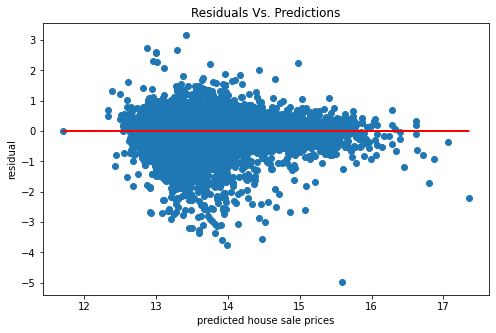

In [35]:
# calculating resid method 2
resid = model_mlr.resid
x_res = model_mlr.predict()


fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x_res, resid)

slope, intercept, r, p, se = linregress(x_res,resid)
lin_r = linregress(x_res, resid)
plt.plot(x_res, lin_r.intercept + lin_r.slope*x_res, 'r')

print('Slope:', slope)
print('Intercept:', intercept)
print('Correlation: (r)', r)

ax.set_xlabel('predicted house sale prices')
ax.set_ylabel('residual')
ax.set_title('Residuals Vs. Predictions');

# 2. Independence
Checking if errors are independent
- Create scatter plot of residuals and target values
    - Evaluete and identify patterns
- Check Durbin-Watson Statistic

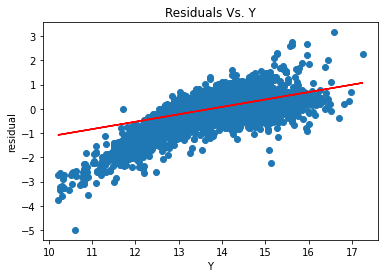

In [36]:
fig, ax = plt.subplots()
ax.scatter(Y, resid)

slope, intercept, r, p, se = linregress(Y,resid)
lin_r = linregress(Y, resid)
plt.plot(Y, lin_r.intercept + lin_r.slope*Y, 'r')

ax.set_xlabel('Y')
ax.set_ylabel('residual')
ax.set_title('Residuals Vs. Y');

- Upward trend in this scatter plot indicates positive correlation in the errors

### Durbin-Watson
- Checks for autocorrelation in the residuals.
- Autocorrelation occurs when residuals are not independent.
- The range is from 0-4 
- values close to 2 indcate no significant autocorrelation (1.5 - 2.5)
- Values below 2 indicate positive autocorrelation
- Values above 2 indicate negative autocorrelation

In [37]:
model_mlr.summary().tables[2]

Omnibus:,16982.055,Durbin-Watson:,1.792
Prob(Omnibus):,0.000,Jarque-Bera (JB):,544429.746
Skew:,-2.248,Prob(JB):,0.00
Kurtosis:,23.681,Cond. No.,387.


## 3. Normality

### Histograms

Resizing the histogram to remove outliers

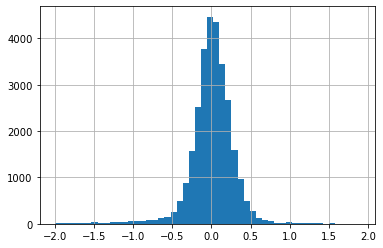

In [38]:
resid[abs(resid) < 2].hist(bins=50,figsize=(6,4));

### QQ Plot

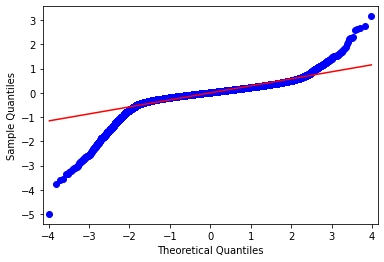

In [39]:
sm.qqplot(resid, line='r');

Based on our assumption tests:
- Passes the multicollinearity test with a Condition number of 387
- Passes Durbin Watson test for independence 
    - Our autocorrelation from the Durbin-Watson test indicates a little to no signifcant autocorrelation
    - Possible positive auto correlation
- Fails Omnibus thus has violated the normality assumption
- QQ plot and Kurtosis indiacates large tails, this is likley due to large outliers  
In summary our model passed 2 of 3 assumptions

When comparing Omnibus and Kurtosis to previous models performing a log transformation of price helped lower both values.

Slope: 0.8974191277484425
Intercept: 156283.72693448525
Correlation: (r) 0.806962663157171


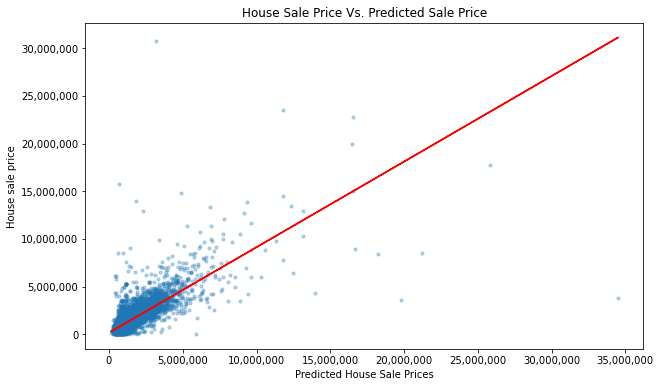

In [40]:
from matplotlib.ticker import StrMethodFormatter, FuncFormatter

fig, ax = plt.subplots(figsize=(10,6))

# Creating model
x_pre = np.exp(model_mlr.predict(X))
y_pre = np.exp(Y)


ax.scatter(x_pre, y_pre,s=10,alpha=.3)

# Removing scientific notation
ax.ticklabel_format(useOffset=False, style='plain')

# Set the major formatter and use fstring notation to adjust the axes
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

slope, intercept, r, p, se = linregress(x_pre,y_pre)
lin_r = linregress(x_pre, y_pre)
plt.plot(x_pre, lin_r.intercept + lin_r.slope*x_pre, 'r')

print('Slope:', slope)
print('Intercept:', intercept)
print('Correlation: (r)', r)

ax.set_xlabel('Predicted House Sale Prices')
ax.set_ylabel('House sale price')
ax.set_title('House Sale Price Vs. Predicted Sale Price');
# plt.savefig('Group_plots/saleprice_predictedprice.png', dpi=100)

In [42]:
df_features = pd.DataFrame(model_mlr.params)
# prices = (np.exp(model_mlr.params)-1)
# list(prices)
df_features = df_features.rename(columns={0:'coef'})
df_features['coef'] = np.exp(df_features['coef'] -1)
df_features

,coef
const,387503.485057
bedrooms,0.369466
bathrooms,0.379827
sqft_living,0.396385
sqft_lot,0.379083
...,...
yr_renovated_2018,0.428491
yr_renovated_2019,0.452436
yr_renovated_2020,0.409711
yr_renovated_2021,0.421578


Slope: 565.382728013178
Intercept: -92211.21803300874
Correlation: (r) 0.6166254384510194


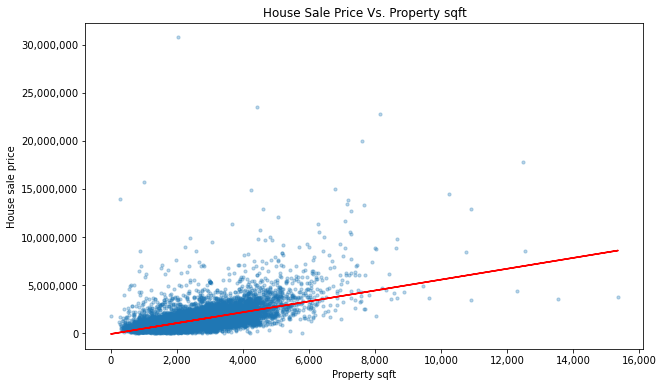

In [43]:
from matplotlib.ticker import StrMethodFormatter, FuncFormatter

fig, ax = plt.subplots(figsize=(10,6))

x_sq = df_clean['sqft_living']
y_p = df_clean['price']
ax.scatter(x_sq, y_p,s=10,alpha=.3)

# Removing scientific notation
ax.ticklabel_format(useOffset=False, style='plain')

# Set the major formatter and use fstring notation to adjust the axes
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

slope, intercept, r, p, se = linregress(x_sq, y_p)
lin_r = linregress(x_sq, y_p)
plt.plot(x_sq, lin_r.intercept + lin_r.slope*x_sq, 'r')

print('Slope:', slope)
print('Intercept:', intercept)
print('Correlation: (r)', r)

ax.set_xlabel('Property sqft')
ax.set_ylabel('House sale price')
ax.set_title('House Sale Price Vs. Property sqft');
# plt.savefig('Group_plots/sqft_price.png', dpi=100)

NameError: name 'X1' is not defined

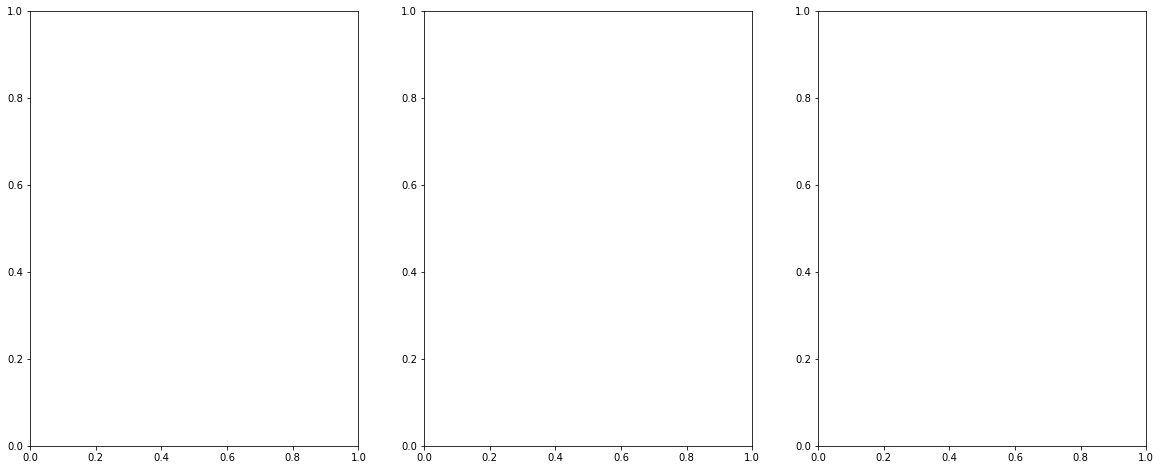

In [44]:
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

axs[0].scatter(df_clean[X1[0]], y1)
axs[0].set_xlabel(f'{X1[0]}')
axs[0].set_ylabel('Price ($)')
axs[0].set_title(f'{X1[0]} vs. Price')

axs[1].scatter(df_clean[X1[1]], y1)
axs[1].set_xlabel(f'{X1[1]}')
axs[1].set_ylabel('Price ($)')
axs[1].set_title(f'{X1[1]} vs. Price')

axs[2].scatter(df_clean[X[2]], y1)
axs[2].set_xlabel(f'{X1[2]}')
axs[2].set_ylabel('Price ($)')
axs[2].set_title(f'{X1[2]} vs. Price')

plt.show()

In [ ]:
# fig, ax = plt.subplots()
# ax.scatter(X,y); 

# ax.set_xlabel('Square Foot Living (ft)')
# ax.set_ylabel('Price ($)')
# ax.set_title('Price of Houses based on Square foot')

# plt.show()

In [ ]:
# sns.lmplot(data=df_cleaned_2, x='sqft_living', y='price')
# plt.xlabel('Sqft Living (sqft)')
# plt.ylabel('Price ($)')
# plt.title('Price against to Sqft Living');